In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Jul_weekend.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 0.000127
  (4,4) => 0.0
  (3,1) => 1697.027235
  (4,5) => 0.003401
  (2,4) => 1337.402518
  (6,5) => 835.13079
  (8,4) => 1307.099997
  (1,2) => 0.0
  (5,1) => 292.8831
  (3,4) => 0.002349
  (8,2) => 999.786874
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 1167.354555
  (2,1) => 709.016964
  (2,5) => 0.0
  (8,5) => 202.14789
  (1,4) => 0.0
  (2,8) => 0.0
  (5,8) => 1312.347367
  (4,8) => 1212.252946
  (7,8) => 0.000478
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 46.66409
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Jul_dict = readall("../temp_files/link_day_minute_Jul_dict_JSON.json");
link_day_minute_Jul_dict = replace(link_day_minute_Jul_dict, "NaN", 0);

link_day_minute_Jul_dict = JSON.parse(link_day_minute_Jul_dict);

In [12]:
# weekend_Jul_list = [1, 7, 8, 14, 15, 21, 22, 28, 29]

# training set 1
weekend_Jul_list_1 = [1, 7, 8, 14, 15, 21]

# training set 2
weekend_Jul_list_2 = [14, 15, 21, 22, 28, 29]

# training set 3
weekend_Jul_list_3 = [1, 7, 8, 22, 28, 29]

arcs_1 = Dict{(Int, Int), Arc}[]
for j in weekend_Jul_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["MD_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in weekend_Jul_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["MD_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in weekend_Jul_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jul_dict[key]["init_node"]
        termNode = link_day_minute_Jul_dict[key]["term_node"]
        capacity = link_day_minute_Jul_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jul_dict[key]["free_flow_time"]
        flow = link_day_minute_Jul_dict[key]["MD_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [14]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [0.000127,0.000127,0.000127,0.000127,0.000127,0.000127]
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [1697.027235,1697.027235,1697.027235,1697.027235,1697.027235,1697.02…
  (4,5) => [0.003401,0.003401,0.003401,0.003401,0.003401,0.003401]
  (2,4) => [1337.402518,1337.402518,1337.402518,1337.402518,1337.402518,1337.40…
  (6,5) => [835.13079,835.13079,835.13079,835.13079,835.13079,835.13079]
  (8,4) => [1307.099997,1307.099997,1307.099997,1307.099997,1307.099997,1307.09…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [292.8831,292.8831,292.8831,292.8831,292.8831,292.8831]
  (3,4) => [0.002349,0.002349,0.002349,0.002349,0.002349,0.002349]
  (8,2) => [999.786874,999.786874,999.786874,999.786874,999.786874,999.786874]
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (2,6) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (5,4) => [1167.354555,1167.354555,1167.354555,1167.354555,1167.354555,1167.35…
  (2,1) => [709.016964,709.016964,709.016964,709.01696

In [15]:
flow_data_3

24x6 Array{Float64,2}:
 2593.62  2649.96  2617.47  2600.39  2613.01  2670.95
 2805.18  2776.74  2819.67  2819.28  2747.59  2833.0 
 2369.43  2345.81  2307.57  2328.86  2389.89  2368.46
 2491.33  2445.83  2467.86  2498.86  2452.47  2450.08
 2353.94  2296.95  2310.29  2268.57  2304.03  2273.45
 2289.0   2383.65  2344.89  2370.89  2362.64  2382.88
 2854.8   2862.85  2909.42  2933.33  2811.0   2821.23
 2786.55  2833.61  2720.88  2835.24  2863.59  2779.18
 2148.55  2282.56  2231.56  2161.25  2176.56  2203.32
 2410.4   2360.93  2410.8   2373.94  2253.55  2431.27
 2549.15  2587.01  2486.63  2619.09  2583.25  2646.56
 2289.01  2410.04  2266.56  2323.17  2493.1   2379.77
 2662.51  2690.82  2755.86  2717.98  2739.15  2662.66
 2663.76  2812.83  2639.54  2263.34  2749.58  2632.17
 2371.73  2376.29  2352.49  2376.83  2294.75  2398.72
 2435.1   2336.6   2301.52  2369.03  2358.73  2328.15
 1896.03  1840.37  1876.17  1884.43  1865.39  1820.92
 2686.45  2898.43  2734.73  2815.12  2937.64  2749.48
 2396

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")

coeffs_dict_Jul_weekend = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Jul_weekend[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Jul_weekend[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Jul_weekend[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [18]:
outfile = open("../temp_files/coeffs_dict_Jul_weekend.json", "w")

JSON.print(outfile, coeffs_dict_Jul_weekend)

close(outfile)

In [19]:
coeffs_dict_Jul_weekend_ = readall("../temp_files/coeffs_dict_Jul_weekend.json")
coeffs_dict_Jul_weekend_ = JSON.parse(coeffs_dict_Jul_weekend_)

Dict{String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.03646081862241558,0.03557465795555787,0.01932921…
  "(5,0.5,100.0,3)"   => {1.0,0.007619877143905153,0.027627993487158265,0.039966…
  "(6,1.5,10.0,3)"    => {1.0,0.02709712198452195,0.0369945575647287,0.026872422…
  "(6,2.0,0.1,2)"     => {1.0,-0.007956376682604656,0.049050322070132164,0.05282…
  "(4,0.5,1000.0,1)"  => {1.0,0.01516367620866686,0.03810950677334009,0.04104527…
  "(6,2.0,0.01,1)"    => {1.0,-0.1222229467328933,0.18683976197047686,0.10803230…
  "(8,1.5,0.01,1)"    => {1.0,-0.1902407050412125,0.18335468751479847,0.35981963…
  "(5,1.5,1.0,1)"     => {1.0,0.034587478003802775,0.038237339536555386,0.021270…
  "(8,2.5,0.001,2)"   => {1.0,-3.1413638499924135,4.127834151182493,2.1832251821…
  "(4,2.0,0.1,1)"     => {1.0,0.04902121613402672,0.03403966785957973,0.00964933…
  "(5,1.0,1000.0,2)"  => {1.0,0.0229525645620906,0.03760670294317555,0.030685635…
  "(4,2.0,0.1,2)"     => {1.0,0.046659990781950884,0.0337601108

In [20]:
coeffs_dict_Jul_weekend_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
  1.0      
 -0.0046171
  0.0535427
 -0.201109 
  0.623062 
 -0.898409 
  0.954502 
 -0.463093 
  0.111308 

INFO: Loading help data...


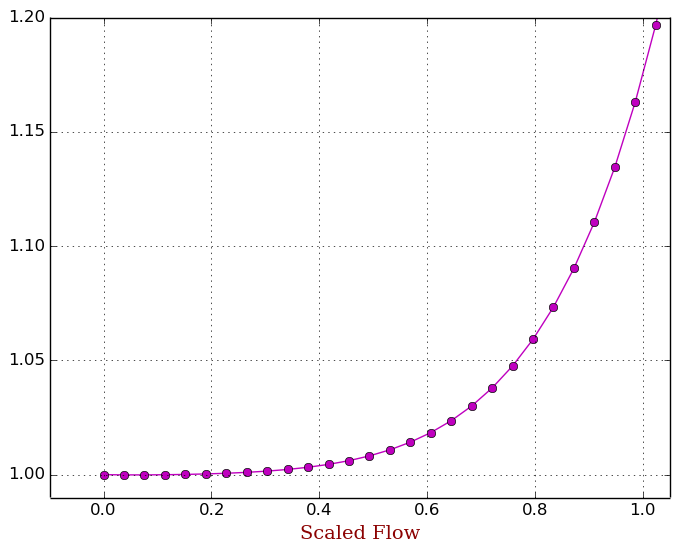

In [21]:
using PyPlot

fcoeffs = coeffs_dict_Jul_weekend_["(8,0.5,0.1,3)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Jul_weekend")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Jul_weekend.pdf")